### Librerias

In [66]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#import joblib
from pickle import dump
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
import warnings

# Ignorar advertencias de ajuste
warnings.filterwarnings("ignore")


In [32]:
conn = sqlite3.connect('accidentes_usa.db')
cursor_obj = conn.cursor()

# Cargar los conjuntos de datos
data = pd.read_sql('SELECT * FROM acc_usa_comp', conn)

# Cerrar la conexión
conn.close()

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178913 entries, 0 to 1178912
Data columns (total 48 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1178913 non-null  object 
 1   Source                 1178913 non-null  object 
 2   Severity               1178913 non-null  int64  
 3   Start_Time             1178913 non-null  object 
 4   End_Time               1178913 non-null  object 
 5   Start_Lat              1178913 non-null  float64
 6   Start_Lng              1178913 non-null  float64
 7   End_Lat                708669 non-null   float64
 8   End_Lng                708669 non-null   float64
 9   Distance(mi)           1178913 non-null  float64
 10  Description            1178912 non-null  object 
 11  Street                 1178476 non-null  object 
 12  City                   1178863 non-null  object 
 13  County                 1178913 non-null  object 
 14  State             

In [34]:
data.isnull().sum()

ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  470244
End_Lng                  470244
Distance(mi)                  0
Description                   1
Street                      437
City                         50
County                        0
State                         0
Zipcode                     358
Country                       0
Timezone                   1343
Airport_Code               3084
Weather_Timestamp         23759
Temperature(F)            30964
Wind_Chill(F)             40163
Humidity(%)               33234
Pressure(in)              25915
Visibility(mi)            30356
Wind_Direction            35789
Wind_Speed(mph)           35761
Precipitation(in)         62402
Weather_Condition         29974
Amenity                       0
Bump                          0
Crossing

### Mejor Curva de Ajuste

In [18]:
df_acc = data.copy()
df_acc.dropna(axis=0, inplace=True)

In [19]:

# Seleccionar la columna que deseas probar
col = df_acc['End_Lat']

# Lista de distribuciones a probar
distribuciones = [
    stats.norm, stats.expon, stats.gamma, stats.beta, stats.lognorm,
    stats.uniform, stats.weibull_min, stats.weibull_max, stats.t, stats.chi2
]
data1=df_acc
# Función para ajustar distribuciones y seleccionar la mejor
def mejor_distribucion(data1):
    resultados = []
    for distribucion in distribuciones:
        params = distribucion.fit(data1)
        # Calcular el valor de la función de verosimilitud
        log_likelihood = distribucion.nnlf(params, data1)
        resultados.append((distribucion.name, log_likelihood, params))
    
    # Seleccionar la distribución con el menor valor de log-likelihood
    mejor_ajuste = min(resultados, key=lambda x: x[1])
    return mejor_ajuste

# Obtener la mejor distribución
mejor_ajuste = mejor_distribucion(col)
print(f"Mejor distribución: {mejor_ajuste[0]}")
print(f"Parámetros: {mejor_ajuste[2]}")


Mejor distribución: beta
Parámetros: (2.522087570071618, 2.4312420680592117, 23.18281026110141, 25.874983716452114)


In [24]:
import pandas as pd
from fitter import Fitter

# asume que 'df' es tu DataFrame y 'column_name' es la columna que deseas ajustar
distributions = [
    'normal',  # Distribución normal
    'exponencial',  # Distribución exponencial
    'uniforme',  # Distribución uniforme
    'lognormal',  # Distribución lognormal
    'gamma',  # Distribución gamma
    'weibull',  # Distribución de Weibull
    'pareto',  # Distribución de Pareto
    'cauchy',  # Distribución de Cauchy
    'logistic',  # Distribución logística
    'gumbel'  # Distribución de Gumbel
]

f = Fitter(df_acc['End_Lat'], distributions=distributions)
f.fit()
print(f.get_best())

{'gamma': {'a': 566.6611682774242, 'loc': -89.2726098307478, 'scale': 0.22176087055427574}}


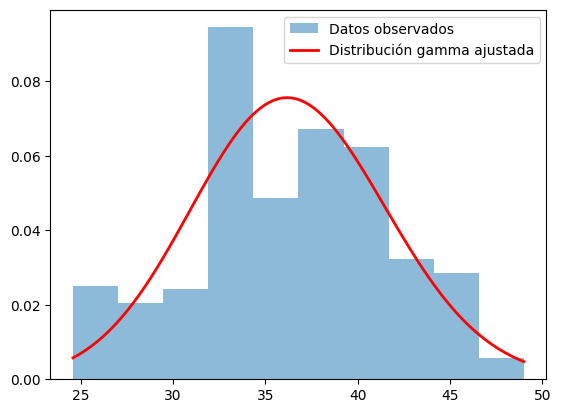

Estadístico D: 0.06098718580090684
Valor p: 0.0
La columna no se ajusta a la distribución gamma (se rechaza H0)


In [25]:
# Seleccionar la columna que deseas probar
columna = df_acc['End_Lat']

# Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(columna)

# Generar valores ajustados
x = np.linspace(min(columna), max(columna), 100)
fitted_pdf = stats.gamma.pdf(x, shape, loc, scale)

# Graficar los datos observados y la distribución ajustada
plt.hist(columna, bins=10, density=True, alpha=0.5, label='Datos observados')
plt.plot(x, fitted_pdf, 'r-', lw=2, label='Distribución gamma ajustada')
plt.legend()
plt.show()

# Realizar una prueba de bondad de ajuste (Kolmogorov-Smirnov)
D, p_value = stats.kstest(columna, 'gamma', args=(shape, loc, scale))

print(f'Estadístico D: {D}')
print(f'Valor p: {p_value}')

# Interpretar el valor p
alpha = 0.05
if p_value > alpha:
    print('La columna se ajusta a la distribución gamma (no se rechaza H0)')
else:
    print('La columna no se ajusta a la distribución gamma (se rechaza H0)')

### Generando  mi propia distribucion de probabilidad

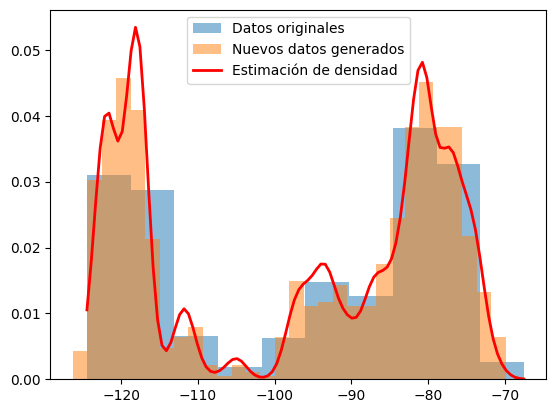

In [27]:
from scipy.stats import gaussian_kde

# Seleccionar la columna que deseas ajustar
columna = df_acc['End_Lng']

# Ajustar una estimación de densidad de kernel (KDE) a los datos
kde = gaussian_kde(columna)

# Generar nuevos datos a partir de la estimación de densidad
nuevos_datos = kde.resample(1000).flatten()

# Graficar los datos originales y los nuevos datos generados
x = np.linspace(min(columna), max(columna), 100)
plt.hist(columna, bins=10, density=True, alpha=0.5, label='Datos originales')
plt.hist(nuevos_datos, bins=30, density=True, alpha=0.5, label='Nuevos datos generados')
plt.plot(x, kde(x), 'r-', lw=2, label='Estimación de densidad')
plt.legend()
plt.show()


### Reemplazando nulos en mi dataset con esta tecnica kde

In [35]:
dataset = data.copy()

# Función para reemplazar valores nulos utilizando KDE
def reemplazar_nulos_kde(columna):
    # Filtrar los valores no nulos
    datos_no_nulos = columna.dropna()
    
    # Ajustar KDE a los datos no nulos
    kde = gaussian_kde(datos_no_nulos)
    
    # Generar nuevos datos para reemplazar los valores nulos
    nuevos_datos = kde.resample(columna.isna().sum()).flatten()
    
    # Reemplazar los valores nulos con los nuevos datos generados
    columna[columna.isna()] = nuevos_datos
    return columna

# Reemplazar valores nulos en las columnas 'End_Lat' y 'End_Lng'
dataset['End_Lat'] = reemplazar_nulos_kde(dataset['End_Lat'])
dataset['End_Lng'] = reemplazar_nulos_kde(dataset['End_Lng'])

dataset.isnull().sum()


ID                           0
Source                       0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                      0
End_Lng                      0
Distance(mi)                 0
Description                  1
Street                     437
City                        50
County                       0
State                        0
Zipcode                    358
Country                      0
Timezone                  1343
Airport_Code              3084
Weather_Timestamp        23759
Temperature(F)           30964
Wind_Chill(F)            40163
Humidity(%)              33234
Pressure(in)             25915
Visibility(mi)           30356
Wind_Direction           35789
Wind_Speed(mph)          35761
Precipitation(in)        62402
Weather_Condition        29974
Amenity                      0
Bump                         0
Crossing                     0
Give_Way

In [36]:
df_final = dataset.copy()
df_final.dropna(axis=0, inplace=True)

In [37]:
df_final.shape

(1093236, 48)

In [38]:
df_final['Severity'].value_counts()

Severity
2    864164
3    174487
4     28862
1     25723
Name: count, dtype: int64

### Balanceo Clase Severity

In [49]:
data_sel=df_final.copy()

# Separando las clases
df_sev_1 = data_sel[data_sel.Severity == 1]
df_sev_2 = data_sel[data_sel.Severity == 2]
df_sev_3 = data_sel[data_sel.Severity == 3]
df_sev_4 = data_sel[data_sel.Severity == 4]

# Submuestreando cada clase a 24.500 registros
df_sev_1_d = resample(df_sev_1, replace=False, n_samples=25700, random_state=42) # para reproducibilidad
df_sev_2_d = resample(df_sev_2, replace=False, n_samples=25700, random_state=42) # para reproducibilidad
df_sev_3_d = resample(df_sev_3, replace=False, n_samples=25700, random_state=42) # para reproducibilidad
df_sev_4_d = resample(df_sev_4, replace=False, n_samples=25700, random_state=42) # para reproducibilidad

# Combinar las clases submuestreadas en un nuevo DataFrame
df_acc_bal = pd.concat([df_sev_1_d, df_sev_2_d, df_sev_3_d, df_sev_4_d])

# Mostrar la distribución de las clases después del submuestreo
print(df_acc_bal['Severity'].value_counts())

Severity
1    25700
2    25700
3    25700
4    25700
Name: count, dtype: int64


In [50]:
df_acc_bal.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,year,dur_acc
908771,A-7015015,Source1,1,2020-05-07 06:07:51,2020-05-07 06:52:51,33.64071,-111.98651,33.64071,-111.98651,0.0,...,0,0,1,0,Day,Day,Day,Day,2020,0.031250
1035257,A-7141532,Source1,1,2020-03-27 20:37:09,2020-03-27 21:05:28,38.21340,-122.13775,38.21340,-122.13775,0.0,...,0,0,0,0,Night,Night,Night,Day,2020,0.019664
901048,A-7007291,Source1,1,2020-05-01 03:24:26,2020-05-01 03:54:26,37.63689,-121.88416,37.63689,-121.88416,0.0,...,0,0,0,0,Night,Night,Night,Night,2020,0.020833
1059575,A-7165857,Source1,1,2020-04-09 05:55:40,2020-04-09 06:10:40,37.40551,-77.26531,37.40551,-77.26531,0.0,...,0,0,0,0,Night,Night,Day,Day,2020,0.010417
644835,A-6749421,Source1,1,2020-07-31 14:31:08,2020-07-31 15:31:08,36.14753,-86.75860,36.14753,-86.75860,0.0,...,0,0,0,0,Day,Day,Day,Day,2020,0.041667


In [51]:
df_acc_bal["Civil_Twilight_n"] = pd.factorize(df_acc_bal["Civil_Twilight"])[0]


In [52]:
df_acc_bal.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,year,dur_acc,Civil_Twilight_n
908771,A-7015015,Source1,1,2020-05-07 06:07:51,2020-05-07 06:52:51,33.64071,-111.98651,33.64071,-111.98651,0.0,...,0,1,0,Day,Day,Day,Day,2020,0.031250,0
1035257,A-7141532,Source1,1,2020-03-27 20:37:09,2020-03-27 21:05:28,38.21340,-122.13775,38.21340,-122.13775,0.0,...,0,0,0,Night,Night,Night,Day,2020,0.019664,1
901048,A-7007291,Source1,1,2020-05-01 03:24:26,2020-05-01 03:54:26,37.63689,-121.88416,37.63689,-121.88416,0.0,...,0,0,0,Night,Night,Night,Night,2020,0.020833,1
1059575,A-7165857,Source1,1,2020-04-09 05:55:40,2020-04-09 06:10:40,37.40551,-77.26531,37.40551,-77.26531,0.0,...,0,0,0,Night,Night,Day,Day,2020,0.010417,1
644835,A-6749421,Source1,1,2020-07-31 14:31:08,2020-07-31 15:31:08,36.14753,-86.75860,36.14753,-86.75860,0.0,...,0,0,0,Day,Day,Day,Day,2020,0.041667,0


In [62]:
df_final['Severity'].value_counts()

Severity
2    864164
3    174487
4     28862
1     25723
Name: count, dtype: int64

In [63]:
df_final["Civil_Twilight_n"] = pd.factorize(df_final["Civil_Twilight"])[0]

In [64]:
#Posibles Variables del Modelo
var_f=['Start_Lat', 'Start_Lng','Traffic_Signal','Civil_Twilight_n','Temperature(F)','Humidity(%)']

X_f=df_final[var_f]
y_f=df_final['Severity']
X_f.head()

,Start_Lat,Start_Lng,Traffic_Signal,Civil_Twilight_n,Temperature(F),Humidity(%)
0,39.376530,-74.478561,0,0,43.0,74.0
1,41.932789,-88.038078,0,0,20.0,81.0
2,41.623920,-87.680061,0,0,22.0,91.0
3,41.794476,-87.631599,1,0,27.0,72.0
4,39.771069,-104.847038,1,0,28.0,69.0


### Conjuntos Train y Test


In [65]:
# Dividir los datos de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3, stratify=y_f, random_state=42)

### Creacion modelo random forest clasiffier

In [67]:
# Crear el modelo de Random Forest
model = RandomForestClassifier(random_state=42)

# Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro')

print(f'F1-score promedio en validación cruzada: {scores.mean()}')

# Entrenar el modelo y evaluar en el conjunto de prueba
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

F1-score promedio en validación cruzada: 0.5719726433673097
              precision    recall  f1-score   support

           1       0.68      0.44      0.53      7717
           2       0.87      0.95      0.91    259249
           3       0.65      0.43      0.52     52346
           4       0.58      0.31      0.41      8659

    accuracy                           0.84    327971
   macro avg       0.70      0.53      0.59    327971
weighted avg       0.82      0.84      0.82    327971



In [68]:
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred),3)}")
predicciones_exactas = accuracy_score(y_test, y_pred, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.838
El número de predicciones exactas es:  274773.0
